# MODIS Chlorophyll Data Processing Pipeline (2005-2011)

This notebook demonstrates loading and processing MODIS L2 Ocean Color satellite data from 2005-2011 to extract and visualize chlorophyll-a concentrations using the correct L2 pipeline approach. It performs the following steps:

1. **Import libraries** and set up the environment.
2. **Define constants** for bounding box and binning parameters.
3. **Search for and load** MODIS L2 OC (Ocean Color) NetCDF files.
4. **Inspect data variables** to identify chlorophyll variable names.
5. **Extract and process** chlorophyll data using the correct `l2_pipeline` approach.
6. **Clip, bin, and plot** the rasterized chlorophyll data.

Data covers June-November for years 2005-2011 from the Texas Louisiana Shelf region.

**Key Pipeline Corrections:**
- Uses L2DatasetLoader with `geophysical_data` group for MODIS L2 OC data
- Handles navigation data properly through LatLonAttacher
- Includes fallback for GPU processing issues

### Library Imports

Import essential libraries for file handling, numerical operations, plotting, and the custom processing pipeline.

In [1]:
# Import essential libraries
import glob
import os
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy.stats import binned_statistic_2d
import xarray as xr # For inspecting NetCDF variables
import matplotlib.colors as colors
import sys
sys.path.append(os.path.abspath(".."))  # adds cdom_sst to path

sys.dont_write_bytecode = True

# Import custom pipeline components
import importlib
from pipelines import l2_pipeline
importlib.reload(l2_pipeline)
from pipelines.l2_pipeline import L2DatasetLoader, GPUDataExtractor, SelectiveInterpolator

# Suppress RuntimeWarnings that can occur with NaNs in calculations
import warnings
warnings.filterwarnings('ignore', category=RuntimeWarning)

print("Libraries imported successfully!")

Libraries imported successfully!


### Define Constants and Parameters

Define the geographical area of interest (Texas Louisiana Shelf bounding box) and parameters for binning the data.

In [2]:
# Geographical Bounding Box - Texas Louisiana Shelf region
lon_min, lon_max = -94.0, -88.0
lat_min, lat_max = 27.5, 30.5

# Binning parameters for rasterized plots
lat_bins = 200 # tall
lon_bins = 300 # wide

# Years to process (2005-2011)
years = [2005, 2006, 2007, 2008, 2009, 2010, 2011]

# --- MODIS L2 Ocean Color Data Configuration ---
# Base directory pattern for MODIS OC files
base_modis_pattern = r"E:\satdata\Texas Louisiana Shelf_{year}-06-01_{year}-11-30"

# L2 MODIS data configuration
chlorophyll_var = 'chlor_a'  # Standard MODIS chlorophyll variable name
modis_data_group = 'geophysical_data'  # L2 MODIS data group
interpolation_threshold = 32  # For selective interpolation

print(f"Configuration set for years: {years}")
print(f"Bounding box: [{lon_min}, {lat_min}] to [{lon_max}, {lat_max}]")
print(f"Target chlorophyll variable: {chlorophyll_var} in group '{modis_data_group}'")

Configuration set for years: [2005, 2006, 2007, 2008, 2009, 2010, 2011]
Bounding box: [-94.0, 27.5] to [-88.0, 30.5]
Target chlorophyll variable: chlor_a in group 'geophysical_data'


### Searching for MODIS L2 Data Files

Search for MODIS Ocean Color L2 NetCDF files across all years (2005-2011).

In [3]:
# Search for MODIS Ocean Color L2 files
nc_files_modis = []
for year in years:
    modis_dir = base_modis_pattern.format(year=year)
    year_files = glob.glob(os.path.join(modis_dir, '**', '*.nc'), recursive=True)
    nc_files_modis.extend(year_files)
    print(f"Year {year}: Found {len(year_files)} MODIS L2 files")

print(f"\nTotal MODIS L2 files found: {len(nc_files_modis)}")

# Limit files for initial testing (remove these lines for full processing)
if len(nc_files_modis) > 50:
    nc_files_modis = nc_files_modis[:50]
    print(f"Limited to {len(nc_files_modis)} MODIS L2 files for testing")

Year 2005: Found 285 MODIS L2 files
Year 2006: Found 291 MODIS L2 files
Year 2007: Found 292 MODIS L2 files
Year 2008: Found 289 MODIS L2 files
Year 2009: Found 284 MODIS L2 files
Year 2010: Found 290 MODIS L2 files
Year 2011: Found 296 MODIS L2 files

Total MODIS L2 files found: 2027
Limited to 50 MODIS L2 files for testing


### Inspecting Variables in MODIS L2 Data

Examine the first MODIS L2 file to verify the data structure and available variables.

In [ ]:
print(f"Inspecting variables in the first MODIS L2 file: {nc_files_modis[0]}")

with xr.open_dataset(nc_files_modis[0], group=modis_data_group) as ds_geo:
    print(f"\nVariables in group '{modis_data_group}':")
    for var_name in ds_geo.variables:
        var = ds_geo[var_name]
        print(f"  {var_name}: {var.dims} - {var.shape}")
        if hasattr(var, 'long_name'):
            print(f"    Long name: {var.long_name}")
        if hasattr(var, 'units'):
            print(f"    Units: {var.units}")
        print()

    with xr.open_dataset(nc_files_modis[0], group='navigation_data') as ds_nav:
        print(f"\nVariables in group 'navigation_data':")
        for var_name in ds_nav.variables:
            var = ds_nav[var_name]
            print(f"  {var_name}: {var.dims} - {var.shape}")
            print()

Inspecting variables in the first MODIS L2 file: E:\satdata\Texas Louisiana Shelf_2005-06-01_2005-11-30\AQUA_MODIS.20050601T192001.L2.OC.nc

Variables in group 'geophysical_data':
  aot_869: ('number_of_lines', 'pixels_per_line') – (2030, 1354)
    Long name: Aerosol optical thickness at 869 nm

  angstrom: ('number_of_lines', 'pixels_per_line') – (2030, 1354)
    Long name: Aerosol Angstrom exponent, 443 to 865 nm

  Rrs_412: ('number_of_lines', 'pixels_per_line') – (2030, 1354)
    Long name: Remote sensing reflectance at 412 nm
    Units: sr^-1

  Rrs_443: ('number_of_lines', 'pixels_per_line') – (2030, 1354)
    Long name: Remote sensing reflectance at 443 nm
    Units: sr^-1

  Rrs_469: ('number_of_lines', 'pixels_per_line') – (2030, 1354)
    Long name: Remote sensing reflectance at 469 nm
    Units: sr^-1

  Rrs_488: ('number_of_lines', 'pixels_per_line') – (2030, 1354)
    Long name: Remote sensing reflectance at 488 nm
    Units: sr^-1

  Rrs_531: ('number_of_lines', 'pixels_p

### Loading MODIS L2 Datasets

Load the MODIS L2 datasets using the correct L2DatasetLoader approach for geophysical_data group.

In [5]:
# Load MODIS L2 datasets using the correct approach
datasets_modis = []
if nc_files_modis:
    try:
        # Use L2DatasetLoader with geophysical_data group for MODIS L2 data
        loader_modis = L2DatasetLoader(variables=[chlorophyll_var], group=modis_data_group)
        datasets_modis = loader_modis.load_multiple(nc_files_modis)
        print(f"Successfully loaded {len(datasets_modis)} MODIS L2 datasets.")
        
        if len(datasets_modis) == 0:
            print("Warning: No datasets were successfully loaded. Check file paths and variable names.")
        else:
            # Show structure of first dataset
            print(f"\nFirst dataset structure:")
            print(f"  Variables: {list(datasets_modis[0].variables)}")
            print(f"  Coordinates: {list(datasets_modis[0].coords)}")
            print(f"  Dimensions: {dict(datasets_modis[0].dims)}")
            
    except Exception as e:
        print(f"Error loading MODIS L2 datasets: {e}")
        print("This might indicate an issue with the pipeline or data structure.")
else:
    print("No MODIS L2 files found to load.")

print(f"\nLoaded {len(datasets_modis)} datasets ready for processing.")

Successfully loaded 50 MODIS L2 datasets.

First dataset structure:
  Variables: ['chlor_a', 'lat', 'lon']
  Coordinates: ['lat', 'lon']
  Dimensions: {'number_of_lines': 2030, 'pixels_per_line': 1354}

Loaded 50 datasets ready for processing.


C:\Users\Makai\AppData\Local\Temp\ipykernel_41896\3633489914.py:17: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  print(f"  Dimensions: {dict(datasets_modis[0].dims)}")


### Data Extraction for Chlorophyll

Extract latitude, longitude, and chlorophyll data using the GPU accelerated extractor with fallback for GPU issues.

In [6]:
# Initialize data arrays
lon_modis_flat, lat_modis_flat, chlor_data_flat = np.array([]), np.array([]), np.array([])

if datasets_modis:
    try:
        print("Attempting GPU-accelerated data extraction...")
        extractor_modis = GPUDataExtractor(variables=[chlorophyll_var])
        lon_modis_flat, lat_modis_flat, chlor_vars_data_flat = extractor_modis.extract(datasets_modis)
        chlor_data_flat = chlor_vars_data_flat[chlorophyll_var]
        print(f"✓ GPU extraction successful! Extracted {len(lon_modis_flat)} data points.")
        
    except Exception as gpu_error:
        print(f"GPU extraction failed: {gpu_error}")
        print("Falling back to CPU-based extraction...")
        
        try:
            # Manual CPU-based extraction as fallback
            all_lons, all_lats, all_chlor = [], [], []
            
            for i, ds in enumerate(datasets_modis):
                if i % 10 == 0:
                    print(f"Processing dataset {i+1}/{len(datasets_modis)}...")
                
                # Extract data from each dataset
                lat_data = ds['lat'].values
                lon_data = ds['lon'].values
                chlor_data = ds[chlorophyll_var].values
                
                # Flatten and filter valid data
                valid_mask = (~np.isnan(lat_data.flatten()) & 
                             ~np.isnan(lon_data.flatten()) & 
                             ~np.isnan(chlor_data.flatten()) & 
                             (chlor_data.flatten() > 0))  # Remove negative chlorophyll
                
                if np.any(valid_mask):
                    all_lats.extend(lat_data.flatten()[valid_mask])
                    all_lons.extend(lon_data.flatten()[valid_mask])
                    all_chlor.extend(chlor_data.flatten()[valid_mask])
            
            # Convert to numpy arrays
            lat_modis_flat = np.array(all_lats)
            lon_modis_flat = np.array(all_lons)
            chlor_data_flat = np.array(all_chlor)
            
            print(f"✓ CPU extraction successful! Extracted {len(lon_modis_flat)} data points.")
            
        except Exception as cpu_error:
            print(f"CPU extraction also failed: {cpu_error}")
            lon_modis_flat, lat_modis_flat, chlor_data_flat = np.array([]), np.array([]), np.array([])
    
    # Print extraction statistics
    if len(chlor_data_flat) > 0:
        print(f"\nExtraction Statistics:")
        print(f"  Total data points: {len(chlor_data_flat)}")
        print(f"  Longitude range: {np.min(lon_modis_flat):.3f} to {np.max(lon_modis_flat):.3f}")
        print(f"  Latitude range: {np.min(lat_modis_flat):.3f} to {np.max(lat_modis_flat):.3f}")
        print(f"  Chlorophyll range: {np.min(chlor_data_flat):.6f} to {np.max(chlor_data_flat):.6f} mg/m³")
        print(f"  Chlorophyll mean: {np.mean(chlor_data_flat):.6f} mg/m³")
    else:
        print("\nNo valid chlorophyll data extracted.")
        
else:
    print("No MODIS L2 datasets loaded, skipping data extraction.")
    lon_modis_flat, lat_modis_flat, chlor_data_flat = np.array([]), np.array([]), np.array([])

Attempting GPU-accelerated data extraction...
✓ GPU extraction successful! Extracted 14348303 data points.

Extraction Statistics:
  Total data points: 14348303
  Longitude range: -120.223 to -61.420
  Latitude range: 8.952 to 49.685
  Chlorophyll range: 0.001000 to 86.370483 mg/m³
  Chlorophyll mean: 0.562000 mg/m³


### Clipping and Binning Chlorophyll Data

Filter the extracted data to the Texas Louisiana Shelf bounding box and create a 2D binned grid for visualization.

In [7]:
# Initialize binned data variables
binned_chlor = np.array([[]])
lon_edges, lat_edges = None, None

if len(lon_modis_flat) > 0 and len(chlor_data_flat) > 0:
    # Clip to bounding box
    clip_mask = ((lon_modis_flat >= lon_min) & (lon_modis_flat <= lon_max) &
                (lat_modis_flat >= lat_min) & (lat_modis_flat <= lat_max))
    
    clipped_lon = lon_modis_flat[clip_mask]
    clipped_lat = lat_modis_flat[clip_mask]
    clipped_chlor = chlor_data_flat[clip_mask]
    
    print(f"Data points within bounding box: {len(clipped_lon)} / {len(lon_modis_flat)}")
    
    if len(clipped_lon) > 0:
        # Create 2D binned statistic
        binned_chlor, lat_edges, lon_edges, _ = binned_statistic_2d(
            clipped_lat, clipped_lon, clipped_chlor,
            statistic='mean', 
            bins=[lat_bins, lon_bins], 
            range=[[lat_min, lat_max], [lon_min, lon_max]]
        )
        
        print(f"2D binning complete for chlorophyll data.")
        print(f"Binned array shape: {binned_chlor.shape}")
        
        # Print statistics of binned data
        valid_binned = binned_chlor[~np.isnan(binned_chlor)]
        if len(valid_binned) > 0:
            print(f"\nBinned chlorophyll statistics:")
            print(f"  Valid bins: {len(valid_binned)} / {binned_chlor.size} ({100*len(valid_binned)/binned_chlor.size:.1f}%)")
            print(f"  Min: {np.min(valid_binned):.6f} mg/m³")
            print(f"  Max: {np.max(valid_binned):.6f} mg/m³")
            print(f"  Mean: {np.mean(valid_binned):.6f} mg/m³")
        else:
            print("\nNo valid data in binned array.")
    else:
        print("No data points within the specified bounding box.")
else:
    print("No chlorophyll data available for binning.")

Data points within bounding box: 984871 / 14348303
2D binning complete for chlorophyll data.
Binned array shape: (200, 300)

Binned chlorophyll statistics:
  Valid bins: 45145 / 60000 (75.2%)
  Min: 0.038050 mg/m³
  Max: 85.801483 mg/m³
  Mean: 2.942305 mg/m³


### Plotting Chlorophyll Data

Visualize the binned chlorophyll data on a map of the Texas Louisiana Shelf region.

Plotting chlorophyll with range: 0.074610 to 13.687540 mg/m³


f:\Programming\GitHub\nasa-murep-local\.venv\Lib\site-packages\cartopy\io\__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_cultural/ne_10m_admin_1_states_provinces_lakes.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


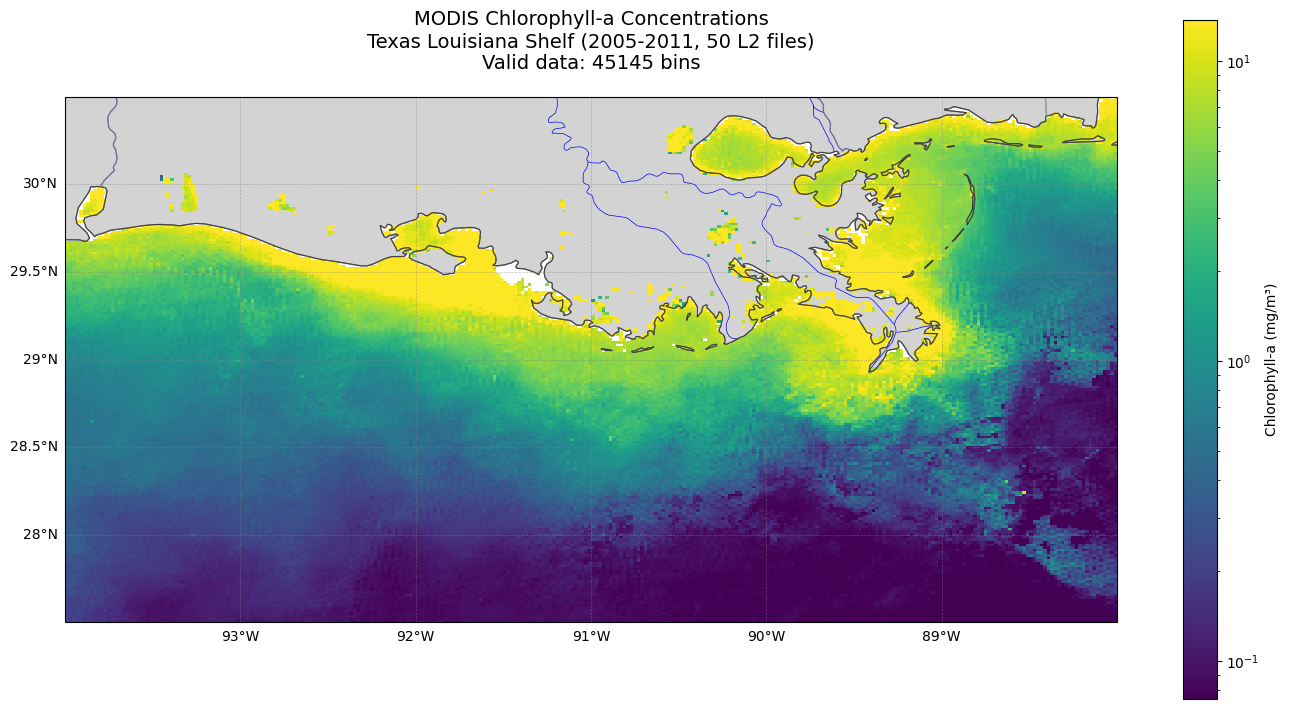

In [8]:
if binned_chlor.size > 0 and lon_edges is not None and lat_edges is not None:
    # Check if we have valid data to plot
    valid_chlor_for_plot = binned_chlor[~np.isnan(binned_chlor)]
    
    if len(valid_chlor_for_plot) > 0:
        fig = plt.figure(figsize=(14, 10))
        ax = plt.axes(projection=ccrs.PlateCarree())
        
        # Set the map extent
        ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
        
        # Determine color scale limits using percentiles to avoid outliers
        vmin = np.percentile(valid_chlor_for_plot, 5)
        vmax = np.percentile(valid_chlor_for_plot, 95)
        
        # Ensure we have reasonable limits for log scale
        if vmin <= 0:
            vmin = 0.01  # Small positive value for log scale
        if vmax <= vmin:
            vmax = vmin * 10
        
        print(f"Plotting chlorophyll with range: {vmin:.6f} to {vmax:.6f} mg/m³")
        
        # Create the plot using log scale (chlorophyll spans orders of magnitude)
        raster = ax.pcolormesh(
            lon_edges, lat_edges, binned_chlor,
            cmap='viridis', shading='auto',
            transform=ccrs.PlateCarree(),
            norm=colors.LogNorm(vmin=vmin, vmax=vmax)
        )
        
        # Add map features
        ax.add_feature(cfeature.COASTLINE, linewidth=0.8, edgecolor='black')
        ax.add_feature(cfeature.LAND, facecolor='lightgray', zorder=0)
        ax.add_feature(cfeature.BORDERS, linestyle=':', edgecolor='gray')
        ax.add_feature(cfeature.RIVERS, linewidth=0.5, edgecolor='blue')
        ax.add_feature(cfeature.STATES, linestyle='-', edgecolor='gray', alpha=0.5)
        
        # Add gridlines
        gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                          linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
        gl.top_labels = False
        gl.right_labels = False
        
        # Colorbar and title
        cbar = plt.colorbar(raster, label='Chlorophyll-a (mg/m³)', shrink=0.7)
        
        plt.title(f"MODIS Chlorophyll-a Concentrations\n" + 
                 f"Texas Louisiana Shelf (2005-2011, {len(datasets_modis)} L2 files)\n" +
                 f"Valid data: {len(valid_chlor_for_plot)} bins", 
                 fontsize=14, pad=20)
        
        plt.tight_layout()
        plt.show()
        
    else:
        print("No valid chlorophyll data available for plotting after binning.")
        print("This could indicate:")
        print("- Data is outside the specified bounding box")
        print("- All chlorophyll values are NaN or invalid")
        print("- Issues with data extraction or processing")
else:
    print("No binned chlorophyll data available for plotting.")
    print("Check previous steps for data loading and processing issues.")

### Optional: Selective Interpolation and Enhanced Visualization

Apply selective interpolation to fill small gaps in the chlorophyll data and create an enhanced comparison visualization.

Applying selective interpolation with threshold: 32 bins...
Selective interpolation complete.


C:\Users\Makai\AppData\Local\Temp\ipykernel_41896\958666639.py:68: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


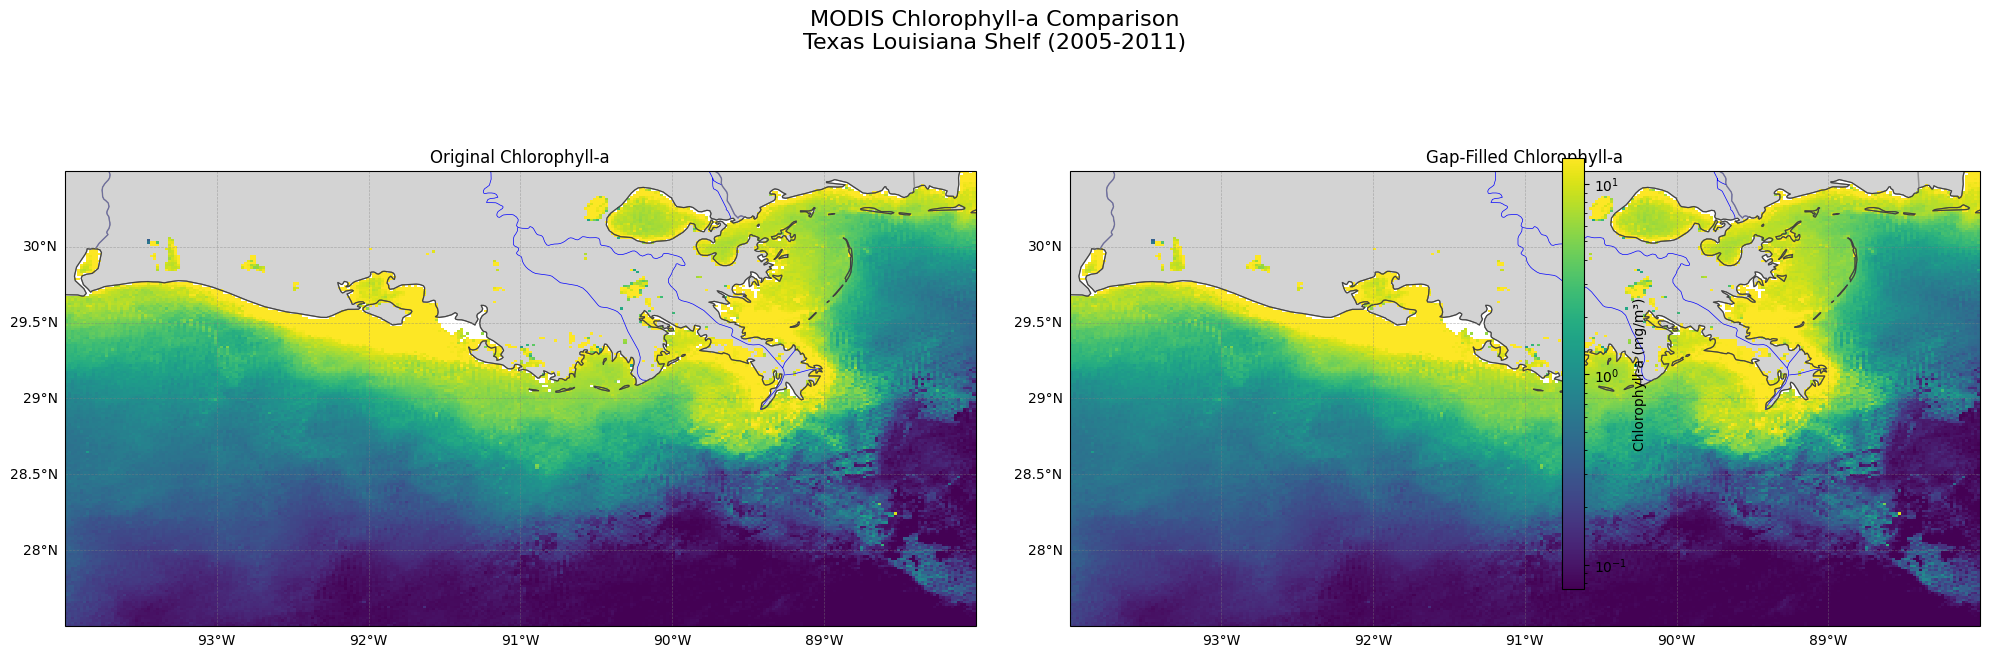


Interpolation results:
  Original valid bins: 45145
  Interpolated valid bins: 45214
  Added bins: 69


In [9]:
# Apply selective interpolation to reduce small gaps
if binned_chlor.size > 0 and lon_edges is not None and lat_edges is not None:
    valid_data_exists = np.any(~np.isnan(binned_chlor))
    
    if valid_data_exists:
        try:
            print(f"Applying selective interpolation with threshold: {interpolation_threshold} bins...")
            chlor_interpolated = SelectiveInterpolator.interpolate(
                binned_chlor, lat_edges, lon_edges, threshold=interpolation_threshold
            )
            print(f"Selective interpolation complete.")
            
            # Create comparison plot
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8), 
                                          subplot_kw={'projection': ccrs.PlateCarree()})
            
            # Set extents for both plots
            for ax in [ax1, ax2]:
                ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
            
            # Determine common color scale
            all_valid_data = np.concatenate([
                binned_chlor[~np.isnan(binned_chlor)],
                chlor_interpolated[~np.isnan(chlor_interpolated)]
            ])
            
            if len(all_valid_data) > 0:
                vmin = np.percentile(all_valid_data, 5)
                vmax = np.percentile(all_valid_data, 95)
                if vmin <= 0:
                    vmin = 0.01
                if vmax <= vmin:
                    vmax = vmin * 10
                
                norm = colors.LogNorm(vmin=vmin, vmax=vmax)
                
                # Original data
                raster1 = ax1.pcolormesh(lon_edges, lat_edges, binned_chlor,
                                       cmap='viridis', shading='auto',
                                       transform=ccrs.PlateCarree(), norm=norm)
                
                # Interpolated data  
                raster2 = ax2.pcolormesh(lon_edges, lat_edges, chlor_interpolated,
                                       cmap='viridis', shading='auto',
                                       transform=ccrs.PlateCarree(), norm=norm)
                
                # Add features to both plots
                for ax, title in zip([ax1, ax2], ['Original', 'Gap-Filled']):
                    ax.add_feature(cfeature.COASTLINE, linewidth=0.8, edgecolor='black')
                    ax.add_feature(cfeature.LAND, facecolor='lightgray', zorder=0)
                    ax.add_feature(cfeature.BORDERS, linestyle=':', edgecolor='gray')
                    ax.add_feature(cfeature.RIVERS, linewidth=0.5, edgecolor='blue')
                    ax.add_feature(cfeature.STATES, linestyle='-', edgecolor='gray', alpha=0.5)
                    
                    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                                     linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
                    gl.top_labels = False
                    gl.right_labels = False
                    
                    ax.set_title(f'{title} Chlorophyll-a', fontsize=12)
                
                # Add single colorbar
                plt.colorbar(raster2, ax=[ax1, ax2], label='Chlorophyll-a (mg/m³)', 
                            shrink=0.7, pad=0.02)
                
                plt.suptitle(f'MODIS Chlorophyll-a Comparison\nTexas Louisiana Shelf (2005-2011)', 
                            fontsize=16, y=0.95)
                plt.tight_layout()
                plt.show()
                
                # Print interpolation statistics
                orig_valid = np.sum(~np.isnan(binned_chlor))
                interp_valid = np.sum(~np.isnan(chlor_interpolated))
                print(f"\nInterpolation results:")
                print(f"  Original valid bins: {orig_valid}")
                print(f"  Interpolated valid bins: {interp_valid}")
                print(f"  Added bins: {interp_valid - orig_valid}")
                
            else:
                print("No valid data available for enhanced visualization.")
                
        except Exception as e:
            print(f"Error during interpolation: {e}")
    else:
        print("No valid data available for interpolation.")
else:
    print("No binned data available for interpolation.")